<i><b>Public AI</b></i>

# Regularization (1) L2 & L1

### _Objective_
* Regularization 정규화에 대해 배워보도록 하겠습니다. <br>
* 대표적인 Regularization 기법인 L1와 L2에 대해 배워보도록 하겠습니다. <br>
  

In [1]:
%matplotlib inline
import os
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

## 예제 데이터 ) 기술투자 비율과 예상 수익률 데이터 셋

기술 투자 비율과 예상 수익률에 대한 데이터셋입니다. <br>
아래와 같이 랜덤으로 50개의 데이터셋을 만들고, Test 데이터셋은 노이즈를 주지 않았습니다.<br>
데이터에 노이즈가 많고, 수가 적을 때 일반적으로 Overfitting이 발생하기 쉽습니다.

In [2]:
random_polynomial = lambda x : 3.5*x**3-4*x**2+x+0.5

train_invests = np.random.uniform(0.05,0.9, 50)
train_growths = np.array([random_polynomial(x)+np.random.normal(0,0.02) 
           for x in train_invests]) # 예상 수익률

train_invests = train_invests.reshape(-1,1) 
train_growths = train_growths.reshape(-1,1) 

test_invests = np.linspace(0.05,0.9,100)
test_growths = np.array([random_polynomial(x)
                         for x in test_invests])

test_invests = test_invests.reshape(-1,1)
test_growths = test_growths.reshape(-1,1)

print("train 데이터셋 크기 : {}".format(len(train_invests)))
print("test 데이터셋 크기 : {}".format(len(test_invests)))

train 데이터셋 크기 : 50
test 데이터셋 크기 : 100


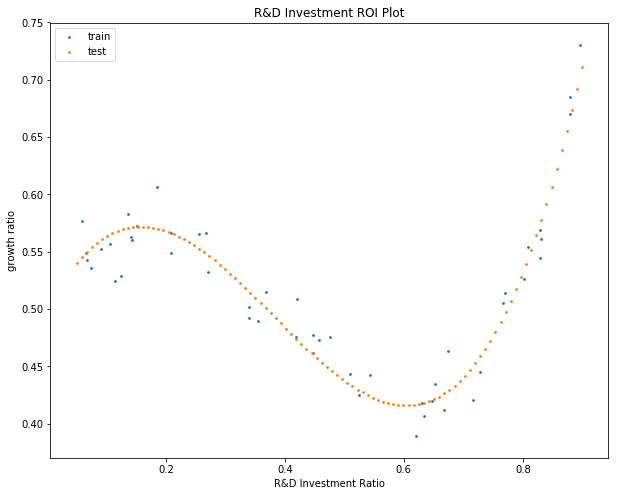

In [3]:
plt.figure(figsize=(10,8))
plt.scatter(train_invests, train_growths, s=3,label='train')
plt.scatter(test_invests, test_growths, s=3,label='test')
plt.title("R&D Investment ROI Plot")
plt.xlabel("R&D Investment Ratio")
plt.ylabel("growth ratio")
plt.legend()
plt.show()

<br><br>

# \[ 1. 정규화의 효과 \]

----

머신러닝 모형에서 정규화란 아래의 의미를 가집니다.
````
Regularization is any modification we make to a learning algorithm
that is intended to reduce its generalization error but not its training error.

-IAN GoodFellow
````
우리는 학습 데이터셋에서만 잘 동작하는 머신러닝 모형이 아닌, 실제 환경에서도 잘 동작하는 모형을 만드는 것을 목표로 합니다. 학습 데이터를 충분하게 수집하는 것은 어렵기 때문에, 많은 경우 소수의 학습 데이터로 모델을 학습시키게 됩니다. 이 경우, 학습 데이터에서만 정확도, 혹은 성능이 매우 높게 나오고 실제 환경에서는 성능이 크게 떨어지는 현상이 발생하는데 이를 Overfitting, 과적합이라고 부릅니다. 또 이렇게 학습 데이터셋에서의 성능과 실제 상황에서의 성능 차이를 줄이는 것을 일반화(Generalization)라고 부릅니다.

우리는 이렇게 일반화를 하기 위해, 다양한 정규화(Regularization) 방법을 이용합니다.

<br>
## 1. 정규화 수식이 없는 인공 신경망

* 데이터가 부족하거나, 노이즈가 많은 상황에서 인공 신경망은 쉽게 과적합이 될 수 있습니다.<br>

### (1) 모델 구성하기

* 3층짜리 신경망을 구성해보도록 하겠습니다.
* 구성한 신경망을 통해 정규화에 따라 어떤식으로 바뀌는지 확인해보도록 하겠습니다.

In [4]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import he_normal, glorot_normal

from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

np.random.seed(30)
if "set_random_seed" in dir(tf.random):
    tf.random.set_random_seed(30)
else:
    tf.random.set_seed(30)

In [5]:
num_hidden1 = 50 # 1번째 은닉층 unit 수
num_hidden2 = 50 # 2번째 은닉층 unit 수

x = Input((1,), name='x')
hidden1 = s
hidden2 = Dense(num_hidden2, 'relu', 
                kernel_initializer=he_normal())(hidden1)
y_pred = Dense(1, kernel_initializer=glorot_normal())(hidden2)
    
model = Model(x, y_pred)
    
model.compile(Adam(1e-2),
              loss=MeanSquaredError(),
              metrics=[RootMeanSquaredError()])

### (2) 구성한 모델 학습하기 

작은 데이터셋에서 epoch을 10000번하는 것은 과적합이 발생하기 쉽습니다.<br>
과적합 현상을 이해하기 위해 과하게 적합하도록 하겠습니다.

In [6]:
start_time = time.time()
history = model.fit(train_invests,
                    train_growths,
                    epochs=10000,
                    verbose=0)

consumed_time = time.time() - start_time # 학습에 총 걸린 시간
print("학습 총 소요 시간 ---- {:.3f}s".format(consumed_time))

학습 총 소요 시간 ---- 29.784s


### (3) 결과 확인하기

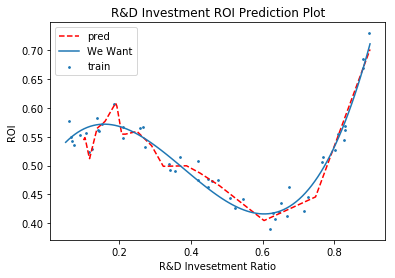

In [7]:
# 0부터 1까지 순서대로 1000개를 출력
test_xs = np.linspace(0.1,0.9,1000)
test_xs = test_xs.reshape(-1,1)
pred_ys = model.predict(test_xs)

plt.plot(test_xs,pred_ys,'r--',label='pred')
plt.plot(test_invests, test_growths,label='We Want')
plt.scatter(train_invests, train_growths, s=3, label='train')
plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.legend()
plt.show()

<br>
## 2. L2 정규화

* 신경망이 데이터를 과적합하는 문제가 발견되었을 때에는 보통 정규화를 적용합니다.<br>
* 가장 대표적인 정규화에는 매개변수의 제곱항을 추가하는 L2 정규화입니다.<br>
* 선형회귀에 L2 정규화를 취해준 모델을 보통 Ridge 선형회귀라고 부릅니다.


### (1) L2 정규화 수식

L2 정규화란, 손실함수에 매개변수의 제곱항을 추가한 것입니다.<br>

$$
\mbox{손실함수 : } J(w,b) = \frac{1}{m}\sum^{m}_{i=1}L(\hat y^{(i)},y^{(i)}) + \frac{\lambda}{2m}||w||^2\\
$$
추가된 항을 보통 L2 Norm, 혹은 Frobenius 노름이라고 부릅니다.<br>
위의 항을 추가하면, 손실함수의 Gradient 식에 변화가 생깁니다.<br>

$$
dW^{[L]} = \mbox{(기존의 역전파로 온 값)} + \frac{\lambda}{m}W^{[L]}
$$
이를 Gradient Descent 수식에 적용하면 수식이 아래와 같이 변형됩니다.<br>
$$
W_{new}^{[L]} = W^{[L]} - \alpha*dW\\
W_{new}^{[L]} = W^{[L]} - \alpha*(\mbox{(기존의 역전파로 온 값)} + \frac{\lambda}{m}W^{[L]})\\
W_{new}^{[L]} = (1-\frac{\alpha \lambda}{m})W^{[L]} - \alpha*(\mbox{(기존의 역전파로 온 값)}
$$

L2 정규화를 취해주게 되면 언제나 Weight값이 좀 더 줄어드는 효과가 생깁니다.<br>
그렇기 때문에 L2 정규화는 다른 말로 Weight decay라고도 불립니다.

### (2) L2 정규화를 케라스에서 구현하기

모든 Weight의 제곱합이 필요합니다. 이를 구현하면 아래와 같이 작성할 수 있습니다.

In [ ]:
num_hidden1 = 50 # 1번째 은닉층 unit 수
num_hidden2 = 50 # 2번째 은닉층 unit 수
beta = 0.0005

x = Input((1,), name='x')
hidden1 = Dense(num_hidden1, 'relu', 
                kernel_initializer=he_normal(), name='hidden1')(x)
hidden2 = Dense(num_hidden2, 'relu', kernel_initializer=he_normal(), name='hidden2')(hidden1)
y_pred = Dense(1, kernel_initializer=glorot_normal(), name='output')(hidden2)
model = Model(x, y_pred)

l2_loss = # TODO
model.add_loss(lambda: l2_loss)    

model.compile(Adam(1e-2),
              loss=[MeanSquaredError()],
              metrics=[RootMeanSquaredError()])

L2 정규화의 경우, API를 이용하여 작성하면 아래와 같이 작성할 수 있습니다.

In [ ]:
from tensorflow.keras.regularizers import l2

num_hidden1 = 50 # 1번째 은닉층 unit 수
num_hidden2 = 50 # 2번째 은닉층 unit 수
beta = 0.0005

x = Input((1,), name='x')
hidden1 = Dense(num_hidden1, 'relu', kernel_initializer=he_normal(), 
                kernel_regularizer=l2(beta), name='hidden1')(x)
hidden2 = Dense(num_hidden2, 'relu', kernel_initializer=he_normal(), 
                kernel_regularizer=l2(beta), name='hidden2')(hidden1)
y_pred = Dense(1, kernel_initializer=glorot_normal(), 
               kernel_regularizer=l2(beta), name='output')(hidden2)
model = Model(x, y_pred)

model.compile(Adam(1e-2),
              loss=[MeanSquaredError()],
              metrics=[RootMeanSquaredError()])

### (3) 구성한 모델 학습하기 

In [ ]:
start_time = time.time()
history = model.fit(train_invests,
                    train_growths,
                    epochs=10000,
                    verbose=0)

consumed_time = time.time() - start_time # 학습에 총 걸린 시간
print("학습 총 소요 시간 ---- {:.3f}s".format(consumed_time))

### (4) 결과 확인하기 

In [ ]:
# 0부터 1까지 순서대로 1000개를 출력
test_xs = np.linspace(0.1,0.9,1000)
test_xs = test_xs.reshape(-1,1)
pred_ys = model.predict(test_xs)


plt.plot(test_invests, test_growths,label='test')
plt.plot(test_xs,pred_ys,'r--',label='pred')
plt.scatter(train_invests, train_growths, s=3,label='train')
plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.legend()
plt.show()

<br>
## 3. L1 정규화

* 매개변수의 절대값을 추가하는 L1 정규화입니다.<br>
* L1 정규화는 수학적으로는 깔끔한 대수적 해가 존재하지 않을 수 있지만, 좀 더 모델이 Noise에 강건하게 만들어준다고 합니다.<br>
* 선형회귀에 L1 정규화를 취해준 모델을 보통 Lasso 선형회귀라고 부릅니다.


### (1) L1 정규화 수식

L2 정규화란, 손실함수에 매개변수의 절대값을 추가한 것입니다.<br>

$$
\mbox{손실함수 : } J(w,b) = \frac{1}{m}\sum^{m}_{i=1}L(\hat y^{(i)},y^{(i)}) + \frac{\lambda}{2m}||w||\\
$$
추가된 항을 보통 L1 Norm이라고 부릅니다.<br>
위의 항을 추가하면, 손실함수의 Gradient 식에 변화가 생깁니다.<br>

$$
dW^{[L]} = \mbox{(기존의 역전파로 온 값)} + \frac{\lambda}{m}sign(W)
$$

L2 정규화와 달리, Weight의 크기에 비례하지 않고, 단순히 Weight의 부호에 의해 결정됩니다.<br>
이 항의 추가로 인해, 0으로 되도 좋은 weight들을 0으로 만드는 효과를 발생합니다.<br>
그래서 L1 정규화는 주로, 특징 선택을 위한 하나의 수단으로도 이용되어 왔습니다.



### (2) L1 정규화를 케라스에서 구현하기

모든 Weight의 절대값이 필요합니다. 이를 구현하면 아래와 같이 작성할 수 있습니다.

In [ ]:
num_hidden1 = 50 # 1번째 은닉층 unit 수
num_hidden2 = 50 # 2번째 은닉층 unit 수
beta = 0.0002

x = Input((1,), name='x')
hidden1 = Dense(num_hidden1, 'relu', kernel_initializer=he_normal(), name='hidden1')(x)
hidden2 = Dense(num_hidden2, 'relu', kernel_initializer=he_normal(), name='hidden2')(hidden1)
y_pred = Dense(1, kernel_initializer=glorot_normal(), name='output')(hidden2)
model = Model(x, y_pred)

l1_loss = # TODO
model.add_loss(lambda: l1_loss)    

model.compile(Adam(1e-2),
              loss=[MeanSquaredError()],
              metrics=[RootMeanSquaredError()])

L1 정규화의 경우, API를 이용하여 작성하면 아래와 같이 작성할 수 있습니다.

In [ ]:
from tensorflow.keras.regularizers import l1

num_hidden1 = 50 # 1번째 은닉층 unit 수
num_hidden2 = 50 # 2번째 은닉층 unit 수
beta = 0.0002

x = Input((1,), name='x')
hidden1 = Dense(num_hidden1, 'relu', kernel_initializer=he_normal(), 
                kernel_regularizer=l1(beta), name='hidden1')(x)
hidden2 = Dense(num_hidden2, 'relu', kernel_initializer=he_normal(), 
                kernel_regularizer=l1(beta), name='hidden2')(hidden1)
y_pred = Dense(1, kernel_initializer=glorot_normal(), 
               kernel_regularizer=l1(beta), name='output')(hidden2)
model = Model(x, y_pred)

model.compile(Adam(1e-2),
              loss=[MeanSquaredError()],
              metrics=[RootMeanSquaredError()])

### (3) L1 Loss 추가한 모델 학습시키기 

In [ ]:
start_time = time.time()
history = model.fit(train_invests,
                    train_growths,
                    epochs=10000,
                    verbose=0)

consumed_time = time.time() - start_time # 학습에 총 걸린 시간
print("학습 총 소요 시간 ---- {:.3f}s".format(consumed_time))

### (4) 결과 확인하기 

In [ ]:
# 0부터 1까지 순서대로 1000개를 출력
test_xs = np.linspace(0.1,0.9,1000)
test_xs = test_xs.reshape(-1,1)
pred_ys = model.predict(test_xs)

plt.plot(test_invests, test_growths,label='test')
plt.plot(test_xs,pred_ys,'r--',label='pred')
plt.scatter(train_invests, train_growths, s=3,label='train')
plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.legend()
plt.show()

## 4. L1 정규화와 L2 정규화 비교

![](https://www.chioka.in/wp-content/uploads/2013/12/L1-norm-and-L2-norm-distance.png)

주로 L1정규화와 L2 정규화를 비교하면 아래와 같습니다.

|차이| L1 정규화 | L2 정규화|
|---|---|---|
|solution uniqueness|단일해를 보장하지 못함|단일해를 보장|
|sparsity|행렬의 원소를 0으로 만듦|행렬의 원소를 0으로 만들지 않음|
|robustness|데이터 내에 노이즈가 많으면 성능이 크게 저하|데이터 내에 노이즈가 많아도 성능이 안정적|

일반적으로 좀 더 안정적인 성능을 보장하는 L2 정규화를 선호하지만 Noise가 많은 상황에서는 L1 정규화가 성능이 보다 좋습니다.


#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/04/05

---